In [1]:
from olfactometer_ingestion import create_device, populate_software_events
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns

In [2]:
TARGET_PATH = Path(r"C:\Users\huy.nguyen\Downloads\20240301T160321 1\20240301T160321")
OLFACTOMETER = create_device("Olfactometer")
ANALOG_INPUT = create_device("AnalogInput")
SOFTWARE_EVENTS = populate_software_events(root_path=TARGET_PATH)

In [3]:
endValve = OLFACTOMETER.EndValveState.read(TARGET_PATH/"Olfactometer.harp/Register__EndValveState.bin")
endValve

,EndValve0,EndValve1,ValveDummy
Time,,,
681743.391488,False,False,False
681743.461504,False,False,False
681758.408480,True,False,False
681760.412480,False,False,False
681770.422496,True,False,False
...,...,...,...
682243.922496,True,False,False
682243.924480,True,False,False
682369.072480,False,False,False


In [4]:
end_valve_rising_edges = endValve["EndValve0"].loc[endValve["EndValve0"].astype(float).diff() == 1.0]
end_valve_rising_edges.head(10)

Time
681758.408480    True
681770.422496    True
681782.435488    True
681794.456480    True
681806.473504    True
681818.484576    True
681830.498496    True
681842.512480    True
681854.524576    True
681866.533504    True
Name: EndValve0, dtype: bool

In [5]:
end_valve_crashing_edges = endValve["EndValve0"].loc[endValve["EndValve0"].astype(float).diff() == -1.0]
end_valve_crashing_edges.head(10)

Time
681760.412480    False
681772.423488    False
681784.446496    False
681796.458496    False
681808.474496    False
681820.487488    False
681832.500480    False
681844.514496    False
681856.526496    False
681868.534496    False
Name: EndValve0, dtype: bool

In [6]:
analog = ANALOG_INPUT.AnalogData.read(TARGET_PATH/"AnalogInput.harp/Register__33.bin")["Channel0"]

In [7]:
endValve.to_csv(r"C:\Users\huy.nguyen\Documents\AIND Services\Olfactometer_R\data\endValve.csv", index = True)
analog.to_csv(r"C:\Users\huy.nguyen\Documents\AIND Services\Olfactometer_R\data\analog.csv", index= True)

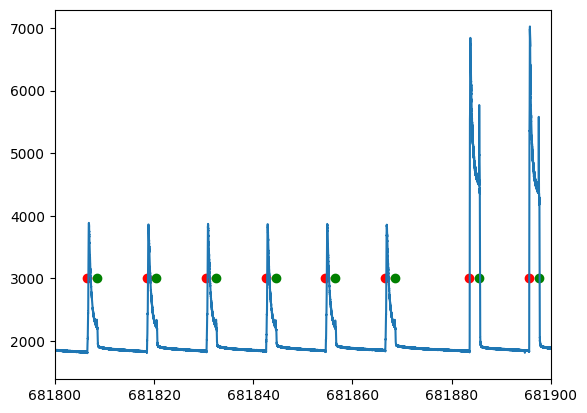

In [8]:

plt.figure()
plt.plot(analog)
plt.scatter(end_valve_rising_edges.index, np.ones_like(end_valve_rising_edges.index) * 3000, c="r") 
plt.scatter(end_valve_crashing_edges.index, np.ones_like(end_valve_crashing_edges.index) * 3000, c="g") 
plt.xlim((681800, 681900))
plt.show()

In [9]:
odor_config = SOFTWARE_EVENTS["OdorConfig"]["data"]
odor_config

Seconds
681743.392000    {'channel_index': 2, 'odorant': 'AmylAcetate',...
681868.532992    {'channel_index': 1, 'odorant': 'AlphaPinene',...
681993.658976    {'channel_index': 0, 'odorant': 'Eugenol', 'od...
682118.772992    {'channel_index': 2, 'odorant': 'AmylAcetate',...
682243.917984    {'channel_index': 1, 'odorant': 'AlphaPinene',...
682369.069984    {'channel_index': 0, 'odorant': 'Eugenol', 'od...
Name: data, dtype: object

In [10]:
pd.DataFrame(odor_config.values.tolist(), index = odor_config.index)

,channel_index,odorant,odorant_dilution,odorant_dilution_unit
Seconds,,,,
681743.392000,2,AmylAcetate,0.1,% v/v
681868.532992,1,AlphaPinene,0.1,% v/v
681993.658976,0,Eugenol,0.1,% v/v
682118.772992,2,AmylAcetate,0.1,% v/v
682243.917984,1,AlphaPinene,0.1,% v/v
682369.069984,0,Eugenol,0.1,% v/v


In [11]:
channel_index = []
odorant = []
for i in range(len(odor_config)):
    val_chan = odor_config.iloc[i]["channel_index"]
    val_odo = odor_config.iloc[i]["odorant"]
    
    channel_index.append(val_chan)
    odorant.append(val_odo)

In [12]:
odo_info = pd.DataFrame(
    {
        'channel_index': channel_index,
        'odorant': odorant
    },
    index = odor_config.index
)
odo_info

,channel_index,odorant
Seconds,,
681743.392000,2,AmylAcetate
681868.532992,1,AlphaPinene
681993.658976,0,Eugenol
682118.772992,2,AmylAcetate
682243.917984,1,AlphaPinene
682369.069984,0,Eugenol


In [13]:
odo_info.to_csv(r"C:\Users\huy.nguyen\Documents\AIND Services\Olfactometer_R\data\odo_info.csv", index = True)

In [14]:
analog = pd.DataFrame(analog)
analog['odo_name'] = ''

analog.head(5)

,Channel0,odo_name
Time,,
681742.376992,1673,
681742.377984,1674,
681742.378976,1676,
681742.380000,1676,
681742.380992,1670,


In [15]:
analog['odo_name'][analog.index < odo_info.index[0]] = "No Odor"
analog['odo_name'][analog.index >= odo_info.index[0]] = odo_info['odorant'].iloc[0]
analog['odo_name'][analog.index >= odo_info.index[1]] = odo_info['odorant'].iloc[1]
analog['odo_name'][analog.index >= odo_info.index[2]] = odo_info['odorant'].iloc[2]
analog['odo_name'][analog.index >= odo_info.index[3]] = odo_info['odorant'].iloc[3]
analog['odo_name'][analog.index >= odo_info.index[4]] = odo_info['odorant'].iloc[4]
analog['odo_name'][analog.index >= odo_info.index[5]] = odo_info['odorant'].iloc[5]

C:\Users\huy.nguyen\AppData\Local\Temp\ipykernel_4044\1731252584.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  analog['odo_name'][analog.index < odo_info.index[0]] = "No Odor"
C:\Users\huy.nguyen\AppData\Local\Temp\ipykernel_4044\17312

In [16]:
analog.head(5)

,Channel0,odo_name
Time,,
681742.376992,1673,No Odor
681742.377984,1674,No Odor
681742.378976,1676,No Odor
681742.380000,1676,No Odor
681742.380992,1670,No Odor


In [17]:
baseline = end_valve_rising_edges.index[0]

analog = analog[analog.index >= baseline]

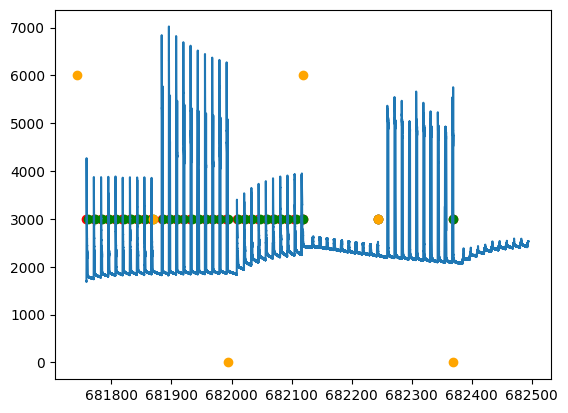

In [18]:
plt.figure()
plt.plot(analog.index, analog['Channel0'])
plt.scatter(end_valve_rising_edges.index, np.ones_like(end_valve_rising_edges.index) * 3000, c="r") 
plt.scatter(end_valve_crashing_edges.index, np.ones_like(end_valve_crashing_edges.index) * 3000, c="g")
plt.scatter(odo_info.index, (odo_info.channel_index) * 3000, c = 'orange')
plt.show()

In [19]:
end_valve_rising_edges.index =  end_valve_rising_edges.index - baseline
end_valve_crashing_edges.index =  end_valve_crashing_edges.index - baseline
analog.index = analog.index - baseline

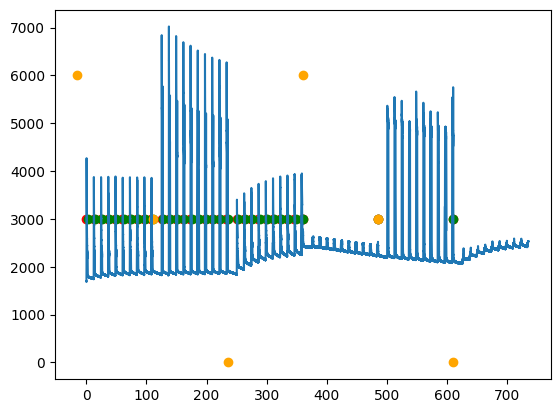

In [20]:
plt.figure()
plt.plot(analog.index, analog['Channel0'])
plt.scatter(end_valve_rising_edges.index, np.ones_like(end_valve_rising_edges.index) * 3000, c="r") 
plt.scatter(end_valve_crashing_edges.index, np.ones_like(end_valve_crashing_edges.index) * 3000, c="g")
plt.scatter(odo_info.index - baseline, (odo_info.channel_index) * 3000, c = 'orange')
plt.show()

In [21]:
end_valve_rising_edges = end_valve_rising_edges.drop([360.36800000001676,485.5140159999719,610.6660159999738])
end_valve_crashing_edges = end_valve_crashing_edges.drop([485.5119999999879, 610.6639999999898])

In [22]:
print(f"Valve ON: {end_valve_rising_edges.head(10)}")
print()
print(f"Valve_OFF: {end_valve_crashing_edges.head(10)}")

Valve ON: Time
0.000000      True
12.014016     True
24.027008     True
36.048000     True
48.065024     True
60.076096     True
72.090016     True
84.104000     True
96.116096     True
108.125024    True
Name: EndValve0, dtype: bool

Valve_OFF: Time
2.004000      False
14.015008     False
26.038016     False
38.050016     False
50.066016     False
62.079008     False
74.092000     False
86.106016     False
98.118016     False
110.126016    False
Name: EndValve0, dtype: bool


In [23]:
cat = []
for i in range(30):
    cat.append('Group_' + str(i))

cat[0:10]

['Group_0',
 'Group_1',
 'Group_2',
 'Group_3',
 'Group_4',
 'Group_5',
 'Group_6',
 'Group_7',
 'Group_8',
 'Group_9']

In [24]:
def fake_valve_input(x):
    current_sec = x
    output_list = []
    check = 10
    
    for i in range(0, 29):
        if check == 10:
            current_sec += 17.25
            output_list.append(current_sec)
            
            check = 1
        else:
            current_sec += 12
            output_list.append(current_sec)
            check += 1
    
    return output_list        
            

In [25]:
valve_open = pd.concat([
    end_valve_rising_edges.reset_index(),
    pd.DataFrame({
        'Time' : fake_valve_input(max(end_valve_rising_edges.index)),
        'EndValve0' : True
        }
                 )
    ]
          )

valve_open = valve_open.set_index('Time')

In [26]:
valve_closed = pd.concat([
    end_valve_crashing_edges.reset_index(),
    pd.DataFrame({
        'Time' : fake_valve_input(max(end_valve_crashing_edges.index)),
        'EndValve0' : True
        }
                 )
    ]
                       )

valve_closed = valve_closed.set_index('Time')

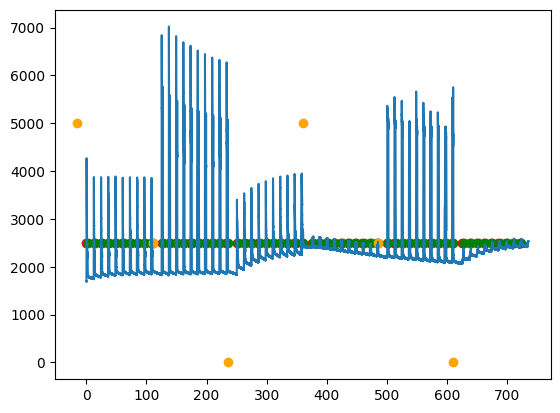

In [27]:
plt.figure()
plt.plot(analog.index, analog['Channel0'])
plt.scatter(valve_open.index, np.ones_like(valve_open.index) * 2500, c="r") 
plt.scatter(valve_closed.index, np.ones_like(valve_closed.index) * 2500, c="g")
plt.scatter(odo_info.index - baseline, (odo_info.channel_index) * 2500, c = 'orange')
plt.show()

analog_index_normalized = []
index_pos = len(valve_open.index) - 1

for i in reversed(analog.index):
    if i > valve_open.index[index_pos]:
        delta = i - valve_open.index[index_pos]
        analog_index_normalized.append(delta)
    else:
        delta = i - valve_open.index[index_pos - 1]
        analog_index_normalized.append(delta)
        index_pos -= 1
        
analog_index_normalized.reverse()

In [28]:
analog_index_normalized = []
cat_sync = []
index_pos = len(valve_open.index) - 1

for i in reversed(analog.index):
    if i > valve_open.index[index_pos]:
        delta = i - valve_open.index[index_pos]
        analog_index_normalized.append(delta)
        cat_index = index_pos - 29 
        cat_sync.append(cat[cat_index])
    else:
        delta = i - valve_open.index[index_pos - 1]
        analog_index_normalized.append(delta)
        cat_sync.append(cat[cat_index - 1])
        index_pos -= 1
        
analog_index_normalized.reverse()
cat_sync.reverse()

In [29]:
norm_analog = analog.copy()
norm_analog["nu_index"] = analog_index_normalized
norm_analog["group"] = cat_sync
norm_analog

,Channel0,odo_name,nu_index,group
Time,,,,
0.000512,1699,AmylAcetate,0.000512,Group_1
0.001504,1700,AmylAcetate,0.001504,Group_1
0.002496,1705,AmylAcetate,0.002496,Group_1
0.003520,1706,AmylAcetate,0.003520,Group_1
0.004512,1699,AmylAcetate,0.004512,Group_1
...,...,...,...,...
735.794496,2532,Eugenol,13.680496,Group_29
735.795520,2531,Eugenol,13.681520,Group_29
735.796512,2536,Eugenol,13.682512,Group_29


In [30]:
tmp = norm_analog[norm_analog["group"] == "Group_5"]

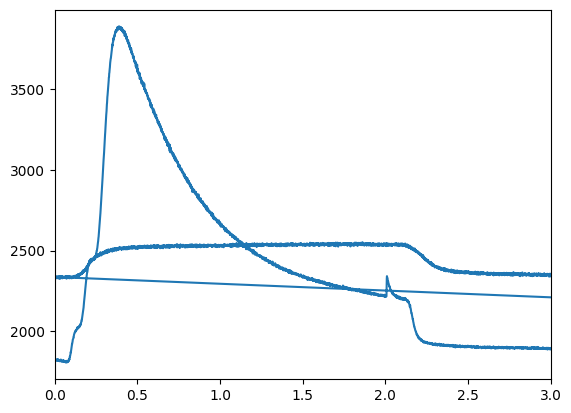

In [31]:
plt.figure()
plt.plot(tmp["nu_index"], tmp["Channel0"])
plt.xlim(0, 3)
plt.show()

In [32]:
norm_analog.to_csv(r"C:\Users\huy.nguyen\Documents\AIND Services\Olfactometer_R\data\norm_analog.csv")

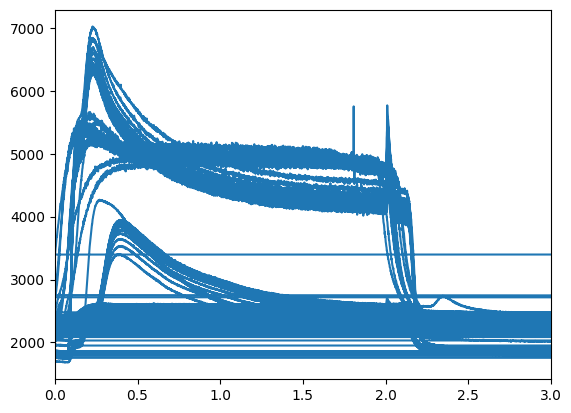

In [33]:
plt.figure()
plt.plot(norm_analog['nu_index'], norm_analog['Channel0'])
plt.xlim(0, 3)
plt.show()

[(0.0, 3.0), Text(0.5, 1.0, 'Independent group for each trial per color')]

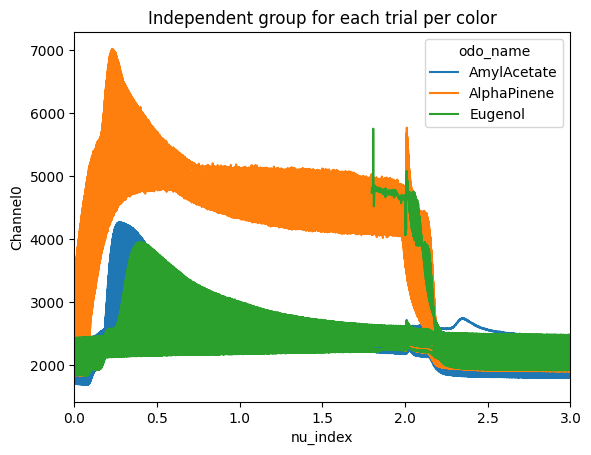

In [34]:
#Group_by color
sns.lineplot(data = norm_analog, x = 'nu_index', y = 'Channel0', units = 'group', hue = 'odo_name', errorbar = None, estimator= None, n_boot= None). \
    set(xlim = (0, 3), title = 'Independent group for each trial per color')